Now that we've established some simple baseline models and demonstrated that the Damped User + Movie Baseline model is the best of the few we tested, let's move on to some actual collaborative filtering models. Here, we'll explore user-based and item-based collaborative filtering. 

![Item-Based vs User-Based](http://www.salemmarafi.com/wp-content/uploads/2014/04/collaborativeFiltering-960x540.jpg)

*Image found on [www.selemmarafi.com](http://www.salemmarafi.com/wp-content/uploads/2014/04/collaborativeFiltering-960x540.jpg)*

The idea of these methods is simply to predict unseen ratings by looking at how similar users rated a particular item, or by looking at how similar items were rated by a particular user. Both methods fall under the category of K-Nearest Neighbor (KNN) models, since ratings from the K most similar users or items are combined for the prediction.

Below, I've implemented a class called `KNNRecommender` that can accept a `mode` parameter of either `'user'` or `'item'`. Let's see how it compares to our best baseline!

# 1. Import necessary modules and classes

In [1]:
# <!-- collapse=True -->
# Import necessary modules
%matplotlib inline
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

# Import User + Movie baseline model from ../baseline_models.py
sys.path.insert(0, '..')
from baseline_models import DampedUserMovieBaselineModel

# Use custom matplotlib stylesheet
plt.style.use('../big-darkgrid.mplstyle')

# 2. Load the Data

In our previous notebook, we set up a `ratings-through-2013.feather` file to make sure we don't touch the holdout data, and to speed up the loading process. Let's load that now, but for the sake of time, for now we'll just use no more than the first 1 million of those ratings anyway.

In [2]:
# <!-- collapse=True -->
# This was created in 02_Baselines.ipynb
ratings_through_2013_feather = '../preprocessed/ratings-through-2013.feather'

if exists(ratings_through_2013_feather):
    print("Loading {}".format(ratings_through_2013_feather))
    ratings_df = pd.read_feather(ratings_through_2013_feather)
else:
    raise ValueError("{} doesn't exits. Run 02_Baselines.ipynb to create.")
display(ratings_df.tail())

Loading ../preprocessed/ratings-through-2013.feather


,userId,movieId,rating,timestamp,year,month,day,hour,minute
19153905,120609,81562,3.0,2013-12-31 23:57:27,2013,12,31,23,57
19153906,120609,356,2.5,2013-12-31 23:57:36,2013,12,31,23,57
19153907,120609,74458,4.0,2013-12-31 23:57:47,2013,12,31,23,57
19153908,44501,70533,4.5,2013-12-31 23:58:07,2013,12,31,23,58
19153909,44501,96821,4.0,2013-12-31 23:58:34,2013,12,31,23,58


# 3. Write our KNNRecommender class

In [3]:
# <!-- collapse=True -->
class KNNRecommender():
    """User-based or Item-based collaborative filtering model that operates on
    dataframes with at least a user-like, item-like, and a rating-like column
    
    Parameters
    ----------
    mode : str, ['item | 'user'], default='item'
        Tells model whether to use item-based or user-based collaborative filtering
    k : int, default=20
        Number of most similar items or users to average for prediction
    basline_algo : object, optional
        Algorithm used to predict baseline scores for each rating. If not provided,
        the mean of all training ratings is used as the baseline. If provided,
        the object must have a fit(X) method and a predict(X) method
    similarity_func : function, default=cosine_similarity
        Function must take a numpy array M of shape (m,n) and return a numpy array
        of shape (m,m) where each element i,j represents the similarity between row
        i and row j of M.
    loop_predict : boolean, default=True
        If True, the model will loop over all user-item pairs in test set and compute
        prediction individually. If False, the model will compute all ratings
        simultaneously. With sparse matrices, looping is typically faster.
        
    Attributes
    ----------
    train_mean : float
        Mean of the training data ratings. Used if baseline_algo is None.
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
        Rating matrix minus baselines
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    knn_indices : 2d numpy array, shape=([n_users|n_items], k)
        Element i,j represents the index of the jth closet [user|item] to i
    knn_similarities : 2d numpy array, shape=([n_users|n_items], k)
        Element i,j represents the similarity between the jth closest [user|item] to i
    """
    def __init__(self, mode='item', k=20, baseline_algo=None,
                 similarity_func=cosine_similarity, loop_predict=True):
        if not mode in ['user', 'item']:
            raise ValueError("'mode' must be either 'user' or 'item', not '{}'!".format(mode))

        self.mode = mode
        self.k = k
        self.baseline_algo = baseline_algo
        self.similarity_func = similarity_func
        self.loop_predict = loop_predict
        
        self.train_mean = None
        self.rating_matrix = None
        self.user_map = None
        self.item_map = None
        self.knn_indices = None
        self.knn_similarities = None
        
    def _get_rating_matrix(self, X):
        """Private function to generate a ratings matrx and mappings for
        the user and item ids to the row and column indices
        
        Parameters
        ----------
        X : pandas.DataFrame, shape=(n_ratings,>=3)
            First 3 columns must be in order of user, item, rating.
        
        Returns
        -------
        rating_matrix : 2d numpy array, shape=(n_users, n_items)
        user_map : pandas Series, shape=(n_users,)
            Mapping from the original user id to an integer in the range [0,n_users)
        item_map : pandas Series, shape=(n_items,)
            Mapping from the original item id to an integer in the range [0,n_items)
        """
        user_col, item_col, rating_col = X.columns[:3]
        rating = X[rating_col]
        user_map = pd.Series(
            index=np.unique(X[user_col]),
            data=np.arange(X[user_col].nunique()),
            name='user_map',
        )
        item_map = pd.Series(
            index=np.unique(X[item_col]),
            data=np.arange(X[item_col].nunique()),
            name='columns_map',
        )
        user_inds = X[user_col].map(user_map)
        item_inds = X[item_col].map(item_map)
        rating_matrix = (
            pd.pivot_table(
                data=X,
                values=rating_col,
                index=user_inds,
                columns=item_inds,
            )
            .fillna(0)
            .values
        )
        return rating_matrix, user_map, item_map

    def _get_knn_indices_and_similarities(self, rating_matrix):
        """Private function to find indices and similarities of k nearest
        neighbors for each user or item
        
        Parameters
        ----------
        rating_matrix : 2d numpy array, shape=(n_users, n_items)
            Matrix of ratings minus baselines
        
        Returns
        -------
        knn_indices : 2d numpy array, shape=([n_users|n_items], k)
            Element i,j represents the index of the jth closet [user|item] to i
        knn_similarities : 2d numpy array, shape=([n_users|n_items], k)
            Element i,j represents the similarity between the jth closest [user|item] to i
        """
        if self.mode == 'item':
            n_users_or_items = rating_matrix.shape[1]
        else:
            n_users_or_items = rating_matrix.shape[0]
        if self.k > n_users_or_items:
            new_k = n_users_or_items - 1
            print(
                "Warning: k = {} > # {}s = {}! Setting k to {}"
                .format(self.k, n_users_or_items, self.mode, new_k)
            )
            self.k = new_k
        if self.mode == 'item':
            similarity_matrix = self.similarity_func(rating_matrix.T)
        else:
            similarity_matrix = self.similarity_func(rating_matrix)
        np.fill_diagonal(similarity_matrix, -1)
        knn_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1][:, :self.k]
        # https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/neighbors/base.py#L373
        sample_range = np.arange(len(knn_indices))[:, None]
        knn_similarities = similarity_matrix[sample_range, knn_indices]
        return knn_indices, knn_similarities
    
    def fit(self, X):
        """Fit model to training data X. Sets the knn_indices, knn_similarities, 
        rating_matrix, user_map, and item map variables.
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        
        Returns
        -------
        self
            This allows chaining like `KNNRecommender().fit(X_train).predict(X_test)`
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean()
            X['rating_baseline'] = self.train_mean
        else:
            self.baseline_algo.fit(X[[user_col, item_col]], X[rating_col])
            X['rating_baseline'] = self.baseline_algo.predict(X[[user_col, item_col]])
        X['rating_diff'] = X[rating_col] - X['rating_baseline']
        nodiff_rating_matrix, _, _ = self._get_rating_matrix(X[[user_col, item_col, rating_col]])
        self.knn_indices, self.knn_similarities = self._get_knn_indices_and_similarities(
            nodiff_rating_matrix
        )
        gc.collect()
        self.rating_matrix, self.user_map, self.item_map = self._get_rating_matrix(
            X[[user_col, item_col, 'rating_diff']]
        )
        return self

    def _predict_1_ui_pair(self, user, item):
        """Predict rating (minus baseline) for 1 user-item pair. Must add
        baseline to get the rating in the original rating scale.
        
        Parameters
        ----------
        user : int
            Must be in range [0, n_users)
        item : int
            Must be in range [0, n_items)
        
        Returns
        -------
        rating_pred : float
            Predicted ratings
        """
        if self.mode == 'item':
            inds_i = self.knn_indices[item, :]
            sims_i = self.knn_similarities[item, :]
            # https://stackoverflow.com/a/35696047/2680824
            numerator = np.sum(self.rating_matrix[user, inds_i] * sims_i)
            denominator = np.sum(np.abs(sims_i))
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred = numerator / denominator
        else:
            inds_u = self.knn_indices[user, :]
            sims_u = self.knn_similarities[user, :]
            # https://stackoverflow.com/a/35696047/2680824
            numerator = np.sum(self.rating_matrix[inds_u, item] * sims_u)
            denominator = np.sum(np.abs(sims_u))
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred = numerator / denominator
        return rating_pred

    def predict(self, X):
        """Predict ratings for each user-item pair in X
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=2)
            First 2 columns of X must correspond to user and item.
        
        Returns
        -------
        pandas Series, shape=(n_ratings,)
            Ratings for each user-item pair in X. No restriction on the data type
            for the user and item ids, other than they must match the training indices.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        X['rating'] = 0
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known = X[known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        if self.loop_predict:
            rating_pred = np.array([
                self._predict_1_ui_pair(u_ind, i_ind)
                for u_ind, i_ind in zip(user_inds, item_inds)
            ])
        else:
            stacked_ratings = self.rating_matrix[
                self.knn_indices[:, :, None],
                np.arange(self.rating_matrix.shape[1])[None, None, :]
            ]
            numerator_matrix = np.sum(
                stacked_ratings * self.knn_similarities[:, :, None],
                axis=1
            )
            denominator_matrix = np.sum(
                (stacked_ratings != 0) * self.knn_similarities[:, :, None],
                axis=1
            )
            # https://stackoverflow.com/a/35696047/2680824
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred_matrix = numerator_matrix / denominator_matrix
            rating_pred = rating_pred_matrix[user_inds, item_inds]
        rating_pred[np.isnan(rating_pred)] = 0
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        return X['rating'] + X['rating_baseline']

In [4]:
def cart_prod(df_1, df_2):
    df_1['_dummy_'], df_2['_dummy_'] = 1, 1
    return pd.merge(df_1, df_2, on='_dummy_').drop('_dummy_', axis=1)

In [5]:
n_ratings_list = [20000, 50000, 100000, 200000, 500000, 1000000]
n_splits = 5

k = 20
mode_list = ['user', 'item']
i_fold_list = np.arange(n_splits)
df_1 = pd.DataFrame({'n': n_ratings_list})
df_2 = pd.DataFrame({'mode': mode_list})
df_3 = pd.DataFrame({'i_fold': i_fold_list})
n_results_df = reduce(cart_prod, [df_1, df_2, df_3])
n_results_df
n_results_df.head(10)

,n,mode,i_fold
0,20000,user,0
1,20000,user,1
2,20000,user,2
3,20000,user,3
4,20000,user,4
5,20000,item,0
6,20000,item,1
7,20000,item,2
8,20000,item,3
9,20000,item,4


In [6]:
pickle_file_name = 'n_results_df.pickle'
if exists(pickle_file_name):
    n_results_df = pd.read_pickle(pickle_file_name)
else:
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    for (n, mode), group in n_results_df.groupby(['n', 'mode']):
        small_df = ratings_df.iloc[:n]
        for (index, row), (train_inds, test_inds) in zip(group.iterrows(), kf.split(small_df)):
            print("n={}, mode={}, i_fold={}: MAE=".format(n, mode, row['i_fold']), end='')
            train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
            baseline_algo = DampedUserMovieBaselineModel(damping_factor=25)
            t1 = datetime.now()
            rec = KNNRecommender(mode=mode, k=k, baseline_algo=baseline_algo)
            rec.fit(train_df)
            preds = rec.predict(test_df[['userId', 'movieId']])
            mae = mean_absolute_error(preds, test_df['rating'])
            n_results_df.loc[index, 'MAE'] = mae
            t2 = datetime.now()
            dt = (t2 - t1).total_seconds()
            print("{:5.3f}   dt={:.2f} seconds".format(mae, dt))
            n_results_df.loc[index, 'time'] = dt
    n_results_df.to_pickle('n_results_df.pickle')

In [7]:
summary_df = (
    n_results_df
    .groupby(('mode', 'n'))[['MAE', 'time']]
    .agg(['mean', 'std'])
    .reset_index()
)
summary_df

mode        n       MAE                 time          
                       mean       std       mean       std
0   item    20000  0.771182  0.002259   0.539737  0.009731
1   item    50000  0.767566  0.003176   0.883605  0.087612
2   item   100000  0.763761  0.003293   1.544236  0.135087
3   item   200000  0.749455  0.002563   3.042951  0.115204
4   item   500000  0.739463  0.002210   7.421341  0.393486
5   item  1000000  0.732431  0.001445  14.633970  0.274141
6   user    20000  0.765788  0.015646   0.546865  0.008997
7   user    50000  0.776194  0.006338   0.934213  0.036221
8   user   100000  0.779116  0.004548   2.007852  0.145059
9   user   200000  0.758879  0.001608   4.929977  0.271024
10  user   500000  0.752004  0.001861  16.710155  0.220937
11  user  1000000  0.741298  0.001843  84.675850  5.142614

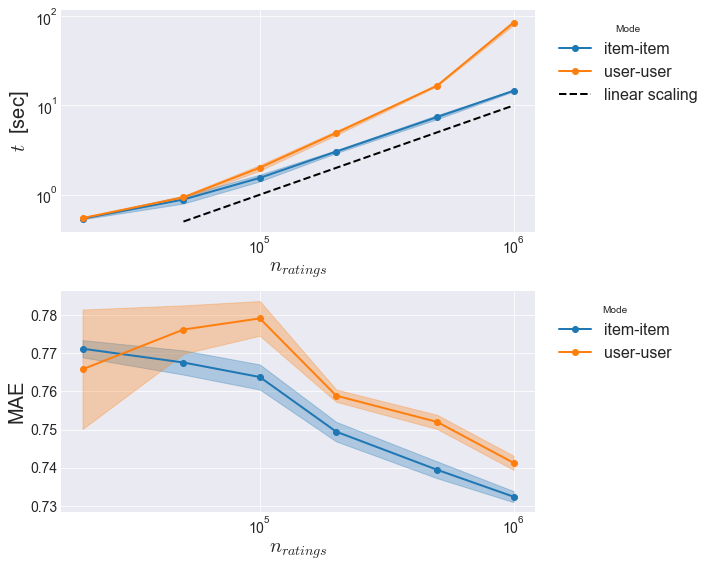

In [8]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8))
for mode, group in summary_df.groupby('mode'):
    l, = ax0.loglog(group['n'], group['time']['mean'], 'o-', label='{0}-{0}'.format(mode))
    ax0.fill_between(
        group['n'],
        group['time']['mean'] - group['time']['std'],
        group['time']['mean'] + group['time']['std'],
        color=l.get_color(),
        alpha=0.3,
    )
ax0.loglog([50000, 1000000], [0.5, 10], 'k--', label='linear scaling')
ax0.set_ylabel(r'$t$  [sec]')
ax0.set_xlabel(r'$n_{ratings}$')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Mode')
# plt.tight_layout()
# plt.show()
for mode, group in summary_df.groupby('mode'):
    l, = ax1.semilogx(group['n'], group['MAE']['mean'], 'o-', label='{0}-{0}'.format(mode))
    ax1.fill_between(
        group['n'],
        group['MAE']['mean'] - group['MAE']['std'],
        group['MAE']['mean'] + group['MAE']['std'],
        color=l.get_color(),
        alpha=0.3,
    )
# plt.loglog([50000, 1000000], [0.5, 10], 'k--', label='linear scaling')
ax1.set_ylabel('MAE')
ax1.set_xlabel(r'$n_{ratings}$')
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Mode')
plt.tight_layout()
plt.show()

In [9]:
n_splits = 5

k_list = [1, 2, 5, 10, 20, 50, 100, 200]
mode_list = ['user', 'item']
i_fold_list = np.arange(n_splits)
df_1 = pd.DataFrame({'k': k_list})
df_2 = pd.DataFrame({'mode': mode_list})
df_3 = pd.DataFrame({'i_fold': i_fold_list})
results_df = reduce(cart_prod, [df_1, df_2, df_3])
results_df.head(10)

,k,mode,i_fold
0,1,user,0
1,1,user,1
2,1,user,2
3,1,user,3
4,1,user,4
5,1,item,0
6,1,item,1
7,1,item,2
8,1,item,3
9,1,item,4


In [10]:
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
small_df = ratings_df.iloc[:100000] #.sample(n=100000)
print(small_df.shape)
for (k, mode), group in results_df.groupby(['k', 'mode']):
    for (index, row), (train_inds, test_inds) in zip(group.iterrows(), kf.split(small_df)):
        print("k={}, mode={}, i_fold={}: MAE=".format(row['k'], row['mode'], row['i_fold']), end='')
        train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
        baseline_algo = DampedUserMovieBaselineModel(damping_factor=25)
        t1 = datetime.now()
        rec = KNNRecommender(mode=row['mode'], k=row['k'], baseline_algo=baseline_algo)
        rec.fit(train_df)
        preds = rec.predict(test_df[['userId', 'movieId']])
        mae = mean_absolute_error(preds, test_df['rating'])
        results_df.loc[index, 'MAE'] = mae
        dt = (datetime.now() - t1).total_seconds()
        print("{:5.3f}   dt={:.2f} seconds".format(mae, dt))
        results_df.loc[index, 'time'] = dt

(100000, 9)
k=1, mode=item, i_fold=0: MAE=0.758   dt=1.96 seconds
k=1, mode=item, i_fold=1: MAE=0.764   dt=1.43 seconds
k=1, mode=item, i_fold=2: MAE=0.765   dt=1.39 seconds
k=1, mode=item, i_fold=3: MAE=0.767   dt=1.41 seconds
k=1, mode=item, i_fold=4: MAE=0.764   dt=1.48 seconds
k=1, mode=user, i_fold=0: MAE=0.771   dt=1.88 seconds
k=1, mode=user, i_fold=1: MAE=0.780   dt=2.41 seconds
k=1, mode=user, i_fold=2: MAE=0.781   dt=2.13 seconds
k=1, mode=user, i_fold=3: MAE=0.781   dt=2.29 seconds
k=1, mode=user, i_fold=4: MAE=0.782   dt=2.10 seconds
k=2, mode=item, i_fold=0: MAE=0.712   dt=1.69 seconds
k=2, mode=item, i_fold=1: MAE=0.721   dt=1.43 seconds
k=2, mode=item, i_fold=2: MAE=0.719   dt=1.49 seconds
k=2, mode=item, i_fold=3: MAE=0.715   dt=1.48 seconds
k=2, mode=item, i_fold=4: MAE=0.719   dt=1.49 seconds
k=2, mode=user, i_fold=0: MAE=0.733   dt=2.09 seconds
k=2, mode=user, i_fold=1: MAE=0.743   dt=1.94 seconds
k=2, mode=user, i_fold=2: MAE=0.745   dt=2.02 seconds
k=2, mode=user, 

In [11]:
baseline_df = pd.DataFrame({'i_fold': i_fold_list})

for (index, row), (train_inds, test_inds) in zip(baseline_df.iterrows(), kf.split(small_df)):
    print("i_fold={}: MAE=".format(row['i_fold']), end='')
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=25)
    baseline_algo.fit(train_df[['userId', 'movieId']], train_df['rating'])
    preds = baseline_algo.predict(test_df[['userId', 'movieId']])
    mae = mean_absolute_error(preds, test_df['rating'])
    baseline_df.loc[index, 'MAE'] = mae
    print("{:5.3f}".format(mae))

i_fold=0: MAE=0.701
i_fold=1: MAE=0.710
i_fold=2: MAE=0.714
i_fold=3: MAE=0.710
i_fold=4: MAE=0.711


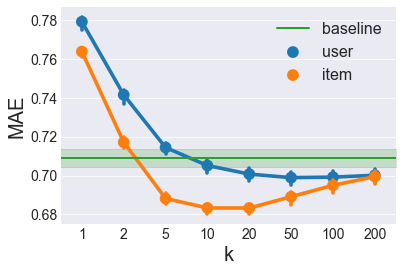

In [12]:
base_avg = baseline_df['MAE'].mean()
base_std = baseline_df['MAE'].std()
sns.pointplot(data=results_df, x='k', hue='mode', y='MAE')
nk = results_df['k'].nunique()
plt.plot([-1, nk], [base_avg, base_avg], label='baseline', color='C2')
plt.fill_between([-1, nk], [base_avg - base_std]*2, [base_avg+base_std]*2, color='C2', alpha=0.2)
plt.legend()
plt.show()